# Analyze sea-level predictions for Greenland by ISMIP6 and Aschwanden et al (2019) [AS19]

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import numpy as np
import os
import pylab as plt
import pandas as pd
import seaborn as sns
import scipy

import matplotlib.lines as mlines
import matplotlib as mpl
import matplotlib.cm as cmx
import matplotlib.colors as colors

from utilities.data_loader import load_imbie_gris, load_ismip6_gris, load_imbie_ais, load_ismip6_ais
from utilities.helper import hist_start, hist_end, proj_start, proj_end, proj_time, secpera

import warnings
warnings.filterwarnings('ignore')

## Plotting helpers

In [80]:
fontsize = 8
lw = 0.65
aspect_ratio = 0.35
markersize = 2

params = {
    "axes.linewidth": 0.25,
    "lines.linewidth": lw,
    "axes.labelsize": fontsize,
    "font.size": fontsize,
    "xtick.direction": "in",
    "xtick.labelsize": fontsize,
    "xtick.major.size": 2.5,
    "xtick.major.width": 0.25,
    "ytick.direction": "in",
    "ytick.labelsize": fontsize,
    "ytick.major.size": 2.5,
    "ytick.major.width": 0.25,
    "legend.fontsize": fontsize,
    "lines.markersize": markersize,
    "font.size": fontsize,
}

plt.rcParams.update(params)


grace_signal_lw = 0.75
mouginot_signal_lw = 0.75
imbie_signal_lw = 0.75
simulated_signal_lw = 0.15
imbie_signal_color = "#005a32"
imbie_sigma_color = "#a1d99b"
imbie_sigma_colors = ["#edf8e9", "#bae4b3", "#74c476"]

simulated_signal_color = "0.7"

gt2cmSLE = 1.0 / 362.5 / 10.0

rcp_list = [26, 85]
rcp_dict = {26: "RCP 2.6", 45: "RCP 4.5", 85: "RCP 8.5"}
rcp_col_dict = {85: "#990002", 45: "#5492CD", 26: "#003466"}
rcp_shade_col_dict = {85: "#F4A582", 45: "#92C5DE", 26: "#4393C3"}
model_ls_dict = {"Model Uncertainty (ISMIP6)": "solid", "Parametric Uncertainty (AS19)": "dashed"}


def set_size(w, h, ax=None):
    """ w, h: width, height in inches """

    if not ax:
        ax = plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w) / (r - l)
    figh = float(h) / (t - b)
    ax.figure.set_size_inches(figw, figh)



## Load ISMIP6 projections

In [4]:
ismip6_ais = load_ismip6_ais(remove_ctrl=True)
ismip6_gris = load_ismip6_gris(remove_ctrl=True)
ismip6_ais["IS"] = "AIS"
ismip6_gris["IS"] = "GRIS"
ismip6 = pd.concat([ismip6_ais, ismip6_gris])

ismip6_ais_ctrl_removed.csv.gz not found locally. Downloading the ISMIP6 archive.
   ...and converting to CSV


## ISMIP6 in numbers

In [5]:
ng = len(ismip6_ais.groupby(by="Group").mean())
nm = len(ismip6_ais.groupby(by="Model").mean())
ne = len(ismip6_ais.groupby(by="Exp").mean())

print(f"Number of modeling groups participated: {ng}")
print(f"Number of ice sheet model configurations used: {nm}")
print(f"Number of experiments: {ne}")

ng = len(ismip6_gris.groupby(by="Group").mean())
nm = len(ismip6_gris.groupby(by="Model").mean())
ne = len(ismip6_gris.groupby(by="Exp").mean())

print(f"Number of modeling groups participated: {ng}")
print(f"Number of ice sheet model configurations used: {nm}")
print(f"Number of experiments: {ne}")

Number of modeling groups participated: 13
Number of ice sheet model configurations used: 14
Number of experiments: 21
Number of modeling groups participated: 13
Number of ice sheet model configurations used: 18
Number of experiments: 9


## Load Observations

In [6]:
imbie_ais = load_imbie_ais()
imbie_gris = load_imbie_gris()
imbie_ais["IS"] = "AIS"
imbie_gris["IS"] = "GRIS"
imbie = pd.concat([imbie_ais, imbie_gris])

## Plot function to reproduce Figure 1 in Aschwanden et al (2021)

In [91]:
def plot_historical(
    out_filename, ismip6, observed, x_lim=[2000, 2025], p_var="Cumulative ice sheet mass change", p_units="Gt"
):
    """
    Plot historical simulations and observations.
    """

    plot_var = f"{p_var} ({p_units})"
    def plot_signal(g, ax):
        m_df = g[-1]
        x = m_df["Year"]
        y = m_df[plot_var]
        return ax.plot(x, y, color=simulated_signal_color, linewidth=simulated_signal_lw)

    fig, axs = plt.subplots(2, 1, sharex="col", figsize=[5.2, 4.25])
    fig.subplots_adjust(hspace=0.1, wspace=0.25)
    
    y_lim = np.array([[-10000, -2000], [10000, 5000]])

    for k, ice_sheet in enumerate(["AIS", "GRIS"]):

        df = ismip6[ismip6["IS"] == ice_sheet]
        imbie = observed[observed["IS"] == ice_sheet]

        [plot_signal(g, axs[k]) for g in df.groupby(by=["Group", "Model", "Exp"])]

        ismip6_mean = df.groupby(by="Year")[plot_var].mean().dropna()
        ismip6_low = df.groupby(by="Year")[plot_var].quantile(0.05).dropna()
        ismip6_high = df.groupby(by="Year")[plot_var].quantile(0.95).dropna()

        ismip6_ci = axs[k].fill_between(
            ismip6_mean.index,
            ismip6_low,
            ismip6_high,
            color="0.0",
            alpha=0.30,
            linewidth=0.0,
            zorder=10,
            label="90% c.i. (ISMIP6) ",
        )

        imbie_cis = []
        for s, sigma in enumerate([3, 2, 1]):
            imbie_ci = axs[k].fill_between(
                imbie["Year"],
                imbie[plot_var] - sigma * imbie["Cumulative ice sheet mass change uncertainty (Gt)"],
                imbie[plot_var] + sigma * imbie["Cumulative ice sheet mass change uncertainty (Gt)"],
                color=imbie_sigma_colors[s],
                alpha=0.5,
                linewidth=0,
                label=f"{sigma}-sigma (IMBIE)"
            )
            imbie_cis.append(imbie_ci)

        imbie_line = axs[k].plot(
            imbie["Year"],
            imbie[plot_var],
            "-",
            color=imbie_signal_color,
            linewidth=imbie_signal_lw,
            label="Observed (IMBIE)",
        )

        axs[k].axvline(proj_start, color="k", linestyle="dashed", linewidth=grace_signal_lw)
        axs[k].axhline(0, color="k", linestyle="dotted", linewidth=grace_signal_lw)

        axs[k].set_xlim(x_lim[0], x_lim[1])
        axs[k].set_ylim(y_lim[0, k], y_lim[1, k])
        ax_sle = axs[k].twinx()
        ax_sle.set_ylabel(f"Contribution to sea-level \nsince {proj_start} (cm SLE)")
        ax_sle.set_ylim(-y_lim[0, k] * gt2cmSLE, -y_lim[1, k] * gt2cmSLE)
        axs[k].set_ylabel(f"{p_var}\nsince {proj_start} ({p_units})")
        axs[k].text(0.025, 0.90, ice_sheet, ha="left", weight="bold", transform=axs[k].transAxes)



    model_line = mlines.Line2D(
        [], [], color=simulated_signal_color, linewidth=simulated_signal_lw, label="Simulated (ISMIP6)"
    )

    axs[0].text(0.59, 0.90, "Historical Period", ha="right", transform=axs[0].transAxes)
    axs[0].text(0.61, 0.90, "Projection Period", ha="left", transform=axs[0].transAxes)


    legend = axs[1].legend(handles=[imbie_line[0], *imbie_cis, model_line, ismip6_ci], loc="upper right")
    legend.get_frame().set_linewidth(0.0)
    legend.get_frame().set_alpha(0.0)


    axs[1].set_xlabel("Year")


    fig.savefig(out_filename, bbox_inches="tight")


## Plot the historical simulations along side observations

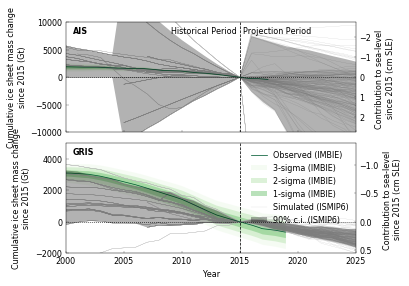

In [92]:
historical_filename = "IS_historical.pdf"
plot_historical(historical_filename, ismip6, imbie)

Unfortunately, most simulations underestimate recent (2008--2020) mass loss. Indeed, the observed record of mass loss lies beyond the 95th percentile of the ISMIP6 experiments. Underestimating recent mass loss likely translates into underestimating mass loss at 2100 as well.  That observations and the ensemble are disjoint implies that model uncertainty is underestimated both now and in the future. 

## Comparison between model and parametric uncertainty

Let us now compare model uncertainty and parametric uncertainty. Here we will use the 500 member ensemble of Aschwanden et al. (2019) [AS19]. We start by loading the AS19 data set.

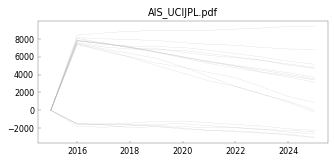

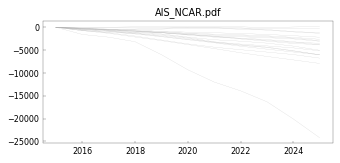

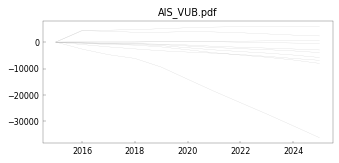

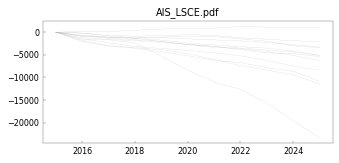

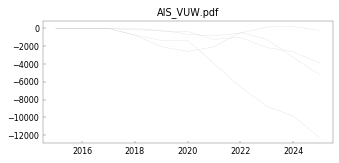

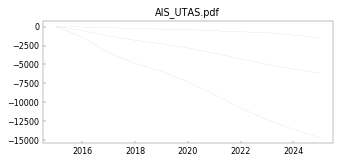

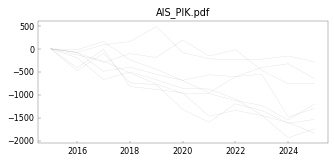

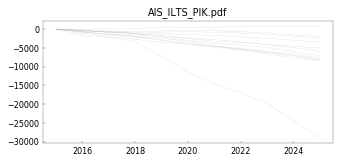

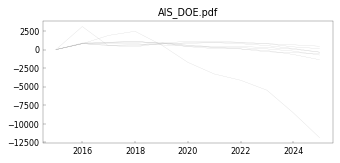

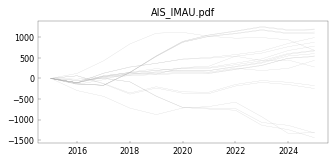

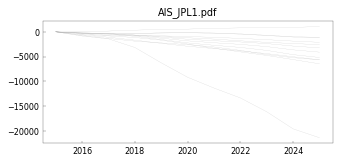

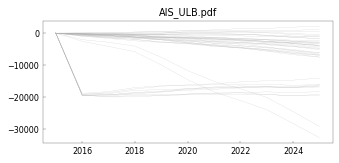

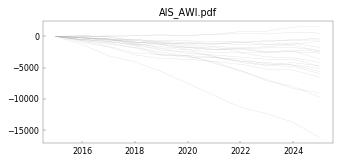

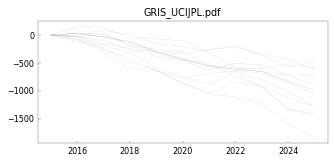

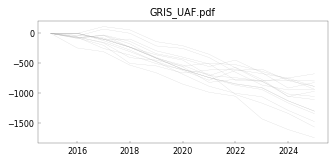

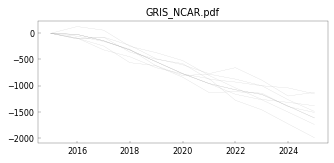

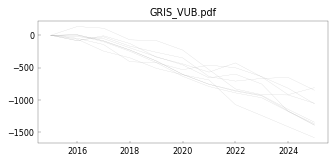

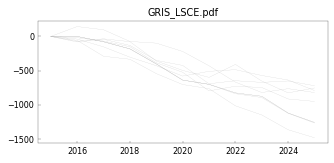

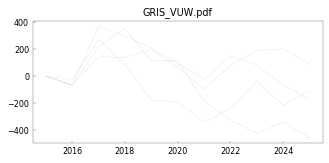

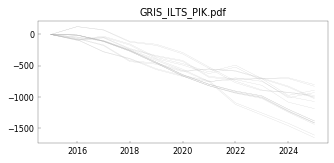

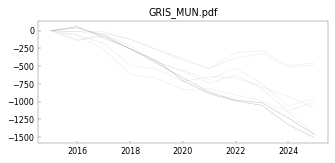

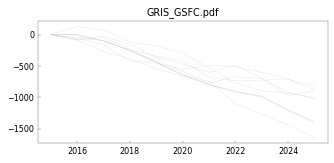

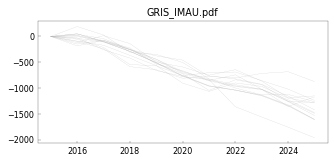

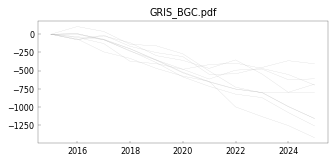

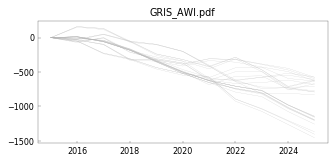

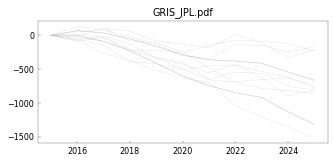

In [11]:
def plot_signal(g, ax):
    m_df = g[-1]
    x = m_df["Year"]
    y = m_df["Cumulative ice sheet mass change (Gt)"]
    return ax.plot(x, y, color=simulated_signal_color, linewidth=simulated_signal_lw)


for ice_sheet in ismip6["IS"].unique():
    is_df = ismip6[(ismip6["IS"] == ice_sheet)]
    groups = is_df["Group"].unique()
    for group in groups:
        df = is_df[(is_df["Group"] == group) & (is_df["Year"] >= proj_start) & (is_df["Year"] <= 2025)]
        fig = plt.figure(figsize=[5.2, 2.25])
        ax = fig.add_subplot(111)
        [plot_signal(g, ax) for g in df.groupby(by=["Model", "Exp"])]
        plt.title(f"{ice_sheet}_{group}.pdf")
        fig.savefig(f"{ice_sheet}_{group}.pdf")
        


In [21]:
 ivol_open = np.array([2.617876e+16, 2.617824e+16, 2.617783e+16, 2.617754e+16, 2.617734e+16, 
    2.617723e+16, 2.617716e+16, 2.61771e+16, 2.617708e+16, 2.61771e+16, 
    2.617713e+16])
 ivol_std = np.array([2.617882e+16, 2.617969e+16, 2.618062e+16, 2.618156e+16, 2.618251e+16, 
    2.618345e+16, 2.618437e+16, 2.618528e+16, 2.618616e+16, 2.618703e+16, 
    2.618787e+16])

In [15]:
 ivol_exp01 = np.array([-1.710363e+12, -1.739403e+12, -1.801351e+12, -1.973921e+12, 
    -2.19168e+12, -2.476137e+12, -2.621821e+12, -2.808496e+12, -2.940803e+12, 
    -3.304831e+12, -3.518158e+12, -3.751457e+12, -4.037063e+12, 
    -4.409468e+12, -4.819782e+12, -5.308288e+12, -5.804816e+12, 
    -6.299419e+12, -6.813145e+12, -7.064605e+12, -7.337331e+12, 
    -7.765733e+12, -8.303031e+12, -8.793931e+12, -9.255691e+12, 
    -9.744986e+12, -1.029565e+13, -1.075237e+13, -1.123874e+13, 
    -1.168912e+13, -1.217263e+13, -1.259524e+13, -1.32361e+13, -1.374403e+13, 
    -1.407459e+13, -1.43597e+13, -1.481633e+13, -1.527383e+13, -1.574794e+13, 
    -1.628098e+13, -1.663785e+13, -1.686111e+13, -1.706537e+13, 
    -1.731048e+13, -1.753214e+13, -1.785844e+13, -1.814517e+13, 
    -1.840758e+13, -1.859382e+13, -1.878699e+13, -1.90949e+13, -1.937491e+13, 
    -1.980693e+13, -1.989218e+13, -2.027329e+13, -2.035694e+13, 
    -2.049101e+13, -2.080439e+13, -2.095464e+13, -2.124771e+13, 
    -2.129778e+13, -2.157572e+13, -2.159334e+13, -2.166921e+13, 
    -2.152923e+13, -2.165691e+13, -2.166543e+13, -2.19349e+13, -2.202543e+13, 
    -2.21841e+13, -2.230119e+13, -2.246523e+13, -2.25368e+13, -2.266131e+13, 
    -2.288389e+13, -2.297442e+13, -2.310391e+13, -2.331206e+13, 
    -2.326875e+13, -2.312815e+13, -2.335793e+13, -2.362878e+13, 
    -2.371069e+13, -2.361921e+13, -2.374014e+13])

In [19]:
np.concatenate([ivol_open-ivol_open[-1], ivol_exp01]) * 910 / 1e12

array([  1483.3    ,   1010.1    ,    637.     ,    373.1    ,
          191.1    ,     91.     ,     27.3    ,    -27.3    ,
          -45.5    ,    -27.3    ,      0.     ,  -1556.43033,
        -1582.85673,  -1639.22941,  -1796.26811,  -1994.4288 ,
        -2253.28467,  -2385.85711,  -2555.73136,  -2676.13073,
        -3007.39621,  -3201.52378,  -3413.82587,  -3673.72733,
        -4012.61588,  -4386.00162,  -4830.54208,  -5282.38256,
        -5732.47129,  -6199.96195,  -6428.79055,  -6676.97121,
        -7066.81703,  -7555.75821,  -8002.47721,  -8422.67881,
        -8867.93726,  -9369.0415 ,  -9784.6567 , -10227.2534 ,
       -10637.0992 , -11077.0933 , -11461.6684 , -12044.851  ,
       -12507.0673 , -12807.8769 , -13067.327  , -13482.8603 ,
       -13899.1853 , -14330.6254 , -14815.6918 , -15140.4435 ,
       -15343.6101 , -15529.4867 , -15752.5368 , -15954.2474 ,
       -16251.1804 , -16512.1047 , -16750.8978 , -16920.3762 ,
       -17096.1609 , -17376.359  , -17631.1681 , -18024

In [22]:
np.concatenate([ivol_std-ivol_std[-1], ivol_exp01]) * 910 / 1e12

array([ -8235.5    ,  -7443.8    ,  -6597.5    ,  -5742.1    ,
        -4877.6    ,  -4022.2    ,  -3185.     ,  -2356.9    ,
        -1556.1    ,   -764.4    ,      0.     ,  -1556.43033,
        -1582.85673,  -1639.22941,  -1796.26811,  -1994.4288 ,
        -2253.28467,  -2385.85711,  -2555.73136,  -2676.13073,
        -3007.39621,  -3201.52378,  -3413.82587,  -3673.72733,
        -4012.61588,  -4386.00162,  -4830.54208,  -5282.38256,
        -5732.47129,  -6199.96195,  -6428.79055,  -6676.97121,
        -7066.81703,  -7555.75821,  -8002.47721,  -8422.67881,
        -8867.93726,  -9369.0415 ,  -9784.6567 , -10227.2534 ,
       -10637.0992 , -11077.0933 , -11461.6684 , -12044.851  ,
       -12507.0673 , -12807.8769 , -13067.327  , -13482.8603 ,
       -13899.1853 , -14330.6254 , -14815.6918 , -15140.4435 ,
       -15343.6101 , -15529.4867 , -15752.5368 , -15954.2474 ,
       -16251.1804 , -16512.1047 , -16750.8978 , -16920.3762 ,
       -17096.1609 , -17376.359  , -17631.1681 , -18024